In [3]:
from numba import jit
import numpy as np
import math

#@jit(nopython=True, cache=True)
#@jit
def calc_sofk(rx, ry, rz, nmax):
    N = rx.size
    cp = np.zeros((3, 2 * nmax + 1, N))
    sp = np.zeros((3, 2 * nmax + 1, N))
    cp[:, 0, :] = 1.0     # this is the k=0 vector
    # these are the contribution of the first k-vector (1,0,0) and symmetries.
    cp[0, 1, :] = np.cos(2 * np.pi * rx[:])
    cp[1, 1, :] = np.cos(2 * np.pi * ry[:])
    cp[2, 1, :] = np.cos(2 * np.pi * rz[:])
    sp[0, 1, :] = np.sin(2 * np.pi * rx[:])
    sp[1, 1, :] = np.sin(2 * np.pi * ry[:])
    sp[2, 1, :] = np.sin(2 * np.pi * rz[:])
    #
    # for n in range(nmax-1):
    for m in range(2,nmax+1):
        cp[:, m, :] = (cp[:, 1, :] * cp[:, m-1, :] -
                       sp[:, 1, :] * sp[:, m-1, :])
        sp[:, m, :] = (sp[:, 1, :] * cp[:, m-1, :] +
                       cp[:, 1, :] * sp[:, m-1, :])
    for m in range(1, nmax+1):
        # impose the symmetry of cos and sin along the axes
        cp[:, -m, :] = cp[:, m, :]
        sp[:, -m, :] = - sp[:, m, :]

    # these are the sum of cos and sin over particles.
    # indices are along the three directions (nx, ny, nz)
    csum = np.zeros((nmax+1, 2*nmax+1, 2*nmax+1), dtype=float)
    ssum = np.zeros((nmax+1, 2*nmax+1, 2*nmax+1), dtype=float)

    for nx in range(0,nmax+1):
        for ny in range(-nmax,nmax+1):
            for nz in range(-nmax,nmax+1):
                csum[nx, ny, nz] = np.sum( cp[0, nx, :] * cp[1, ny, :] * cp[2, nz, :]
                                        - cp[0, nx, :] * sp[1, ny, :] * sp[2, nz, :]
                                        - sp[0, nx, :] * sp[1, ny, :] * cp[2, nz, :]
                                        - sp[0, nx, :] * cp[1, ny, :] * sp[2, nz, :])
                ssum[nx, ny, nz] = np.sum( sp[0, nx, :] * cp[1, ny, :] * cp[2, nz, :]
                                        + cp[0, nx, :] * sp[1, ny, :] * cp[2, nz, :]
                                        + cp[0, nx, :] * cp[1, ny, :] * sp[2, nz, :]
                                        - sp[0, nx, :] * sp[1, ny, :] * sp[2, nz, :])
#               for k in range(N):
#                   csum[nx, ny, nz] += ( cp[0, nx, k] * cp[1, ny, k] * cp[2, nz, k]
#                                       - cp[0, nx, k] * sp[1, ny, k] * sp[2, nz, k]
#                                       - sp[0, nx, k] * sp[1, ny, k] * cp[2, nz, k]
#                                       - sp[0, nx, k] * cp[1, ny, k] * sp[2, nz, k])
#                   ssum[nx, ny, nz] += ( sp[0, nx, k] * cp[1, ny, k] * cp[2, nz, k]
#                                       + cp[0, nx, k] * sp[1, ny, k] * cp[2, nz, k]
#                                       + cp[0, nx, k] * cp[1, ny, k] * sp[2, nz, k]
#                                       - sp[0, nx, k] * sp[1, ny, k] * sp[2, nz, k])
 
    sofk = np.zeros((nmax+1, 2*nmax+1, 2*nmax+1), dtype=float)
    sofk = (csum**2 + ssum**2) / N
    return sofk

1
2
3
4
5
6
7
8
9
10


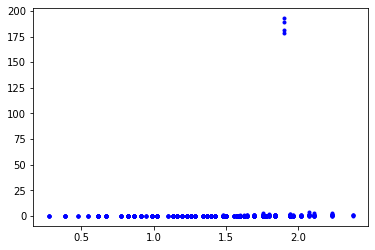

In [4]:
#if __name__ == '__main__':
import numpy as np
import math
from matplotlib.pyplot import plot, show
#%matplotlib widget

nmax=5    #nmax is the number of maximum k-vec in each direction
sofk=np.zeros((nmax+1,2*nmax+1,2*nmax+1))
with open('trajectory.xyz') as fdat:
    count = 0
    part_num = int(fdat.readline())
    while part_num != '':
        part_num = int(part_num)
        count += 1
        if (count)%1==0 :
            print(count)
        rx = np.zeros(part_num)
        ry = np.zeros(part_num)
        rz = np.zeros(part_num)
        #fdat.readline()
        Lx, Ly, Lz = [ float(value) for value in fdat.readline().split() ]
        for ind in range(part_num):
            rx[ind], ry[ind], rz[ind] = [
                float(value) for value in fdat.readline().split()[1:]]
        sofk+=calc_sofk(rx/Lx,ry/Ly,rz/Lz,nmax)
        part_num = fdat.readline()

sofk=sofk/count
nvec = (nmax+1)*(2*nmax+1)**2
kmod = np.zeros(nvec)
kvec = np.zeros((3,nvec))
sofk_kvec = np.zeros(nvec)
ix=-1
for nx in range(0,nmax+1):
    for ny in range(-nmax,nmax+1):
        for nz in range(-nmax,nmax+1):
            ix += 1
            kmod[ix] = 2*np.pi * np.sqrt((nx/Lx)**2+(ny/Ly)**2+(nz/Lz)**2)
            kvec[0,ix] = 2 * np.pi * nx / Lx
            kvec[1,ix] = 2 * np.pi * ny / Ly
            kvec[2,ix] = 2 * np.pi * nz / Lz
            sofk_kvec[ix] = sofk[nx,ny,nz]
            #print(ix,kmod[ix],sofk_kvec[ix])

sout=np.column_stack( (kmod[np.argsort(kmod)],kvec[0,np.argsort(kmod)],kvec[1,np.argsort(kmod)],kvec[2,np.argsort(kmod)],sofk_kvec[np.argsort(kmod)]) )
np.savetxt('sofk.dat',sout[1:,], fmt=('%12.7g','%12.7g','%12.7g','%12.7g','%12.7g'), header="    '|k|'  'kx' 'ky' 'kz' 'S(k)'")

#plot(kmod,sofk_kvec,'b.')
kappa=kmod[np.argsort(kmod)][1:]
sakka=sofk_kvec[np.argsort(kmod)][1:]
plot(kappa,sakka,'b.')
show()